# Final Project Modelling (Clustering) - Stage 2

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.cluster import KMeans, AgglomerativeClustering, BisectingKMeans, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler

## Load Final Datasets

In [21]:
df_model = pd.read_csv('https://raw.githubusercontent.com/valencya07/Final-Project/refs/heads/stage-2/dataset_final.csv')
df_model.sample(5)

,job_title,source,avg_time_to_hire,avg_cost_per_hire,avg_OAR,hiring_count,efficiency_score,efficiency_score_scaled,avg_time_to_hire_scaled,avg_cost_per_hire_scaled,avg_OAR_scaled
1,Account Executive,LinkedIn,44.326923,4464.992500,0.633077,52,-0.396358,0.859345,-0.587495,-1.610114,-0.483420
90,UX Designer,Recruiter,41.687500,5450.451042,0.618333,48,-0.489055,-0.125866,-1.128533,0.449520,-0.840365
79,Software Engineer,Referral,47.410256,4697.476410,0.685641,39,-0.383362,0.997478,0.044538,-1.124217,0.789165
20,Data Engineer,Job Portal,46.145161,5660.922419,0.656129,62,-0.511597,-0.365450,-0.214786,0.889411,0.074675
4,Accountant,Job Portal,43.020000,5221.758000,0.679000,50,-0.394545,0.878622,-0.855393,-0.028454,0.628385


In [22]:
#Scaling efficiency_score agar interpretasi bisnis nya lebih mudah
# Inisialisasi Scaler
scaler_100 = MinMaxScaler(feature_range=(0, 100))

# Jika 'efficiency_score' tinggi berarti BAGUS (Efisiensi):
df_model['efficiency_score_final'] = scaler_100.fit_transform(df_model[['efficiency_score']])

# TAPI, Jika aslinya 'Difficulty Score' (tinggi berarti SULIT), gunakan ini agar 100 = Mudah:
# df_model['efficiency_score_final'] = 100 - scaler_100.fit_transform(df_model[['difficulty_score']])

print("Skor efisiensi sekarang berada di rentang 0 - 100")
display(df_model[['job_title', 'source', 'efficiency_score_final']].head())

Skor efisiensi sekarang berada di rentang 0 - 100


,job_title,source,efficiency_score_final
0,Account Executive,Job Portal,75.116065
1,Account Executive,LinkedIn,82.090749
2,Account Executive,Recruiter,70.633330
3,Account Executive,Referral,34.651234
4,Accountant,Job Portal,82.746219


## Feature Selection

In [23]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   job_title                 92 non-null     object 
 1   source                    92 non-null     object 
 2   avg_time_to_hire          92 non-null     float64
 3   avg_cost_per_hire         92 non-null     float64
 4   avg_OAR                   92 non-null     float64
 5   hiring_count              92 non-null     int64  
 6   efficiency_score          92 non-null     float64
 7   efficiency_score_scaled   92 non-null     float64
 8   avg_time_to_hire_scaled   92 non-null     float64
 9   avg_cost_per_hire_scaled  92 non-null     float64
 10  avg_OAR_scaled            92 non-null     float64
 11  efficiency_score_final    92 non-null     float64
dtypes: float64(9), int64(1), object(2)
memory usage: 8.8+ KB


In [24]:
# Hanya menggunakan avg_time_to_hire_scaled, avg_cost_per_hire_scaled, avg_OAR_scaled untuk clustering karena
#ketiga itu merupakan feature KPI dari kasus ini
X_clustering = df_model[[
    'avg_time_to_hire_scaled',
    'avg_cost_per_hire_scaled',
    'avg_OAR_scaled'
]]

print("Data siap! Fitur yang digunakan untuk clustering adalah:")
print(X_clustering.columns.tolist())
print(f"\nJumlah baris: {len(X_clustering)}")
X_clustering.head()

Data siap! Fitur yang digunakan untuk clustering adalah:
['avg_time_to_hire_scaled', 'avg_cost_per_hire_scaled', 'avg_OAR_scaled']

Jumlah baris: 92


,avg_time_to_hire_scaled,avg_cost_per_hire_scaled,avg_OAR_scaled
0,-0.516733,-0.956609,-0.180869
1,-0.587495,-1.610114,-0.483420
2,0.569998,-0.450687,1.136798
3,-0.188272,-0.147871,-1.056357
4,-0.855393,-0.028454,0.628385


## Modeling

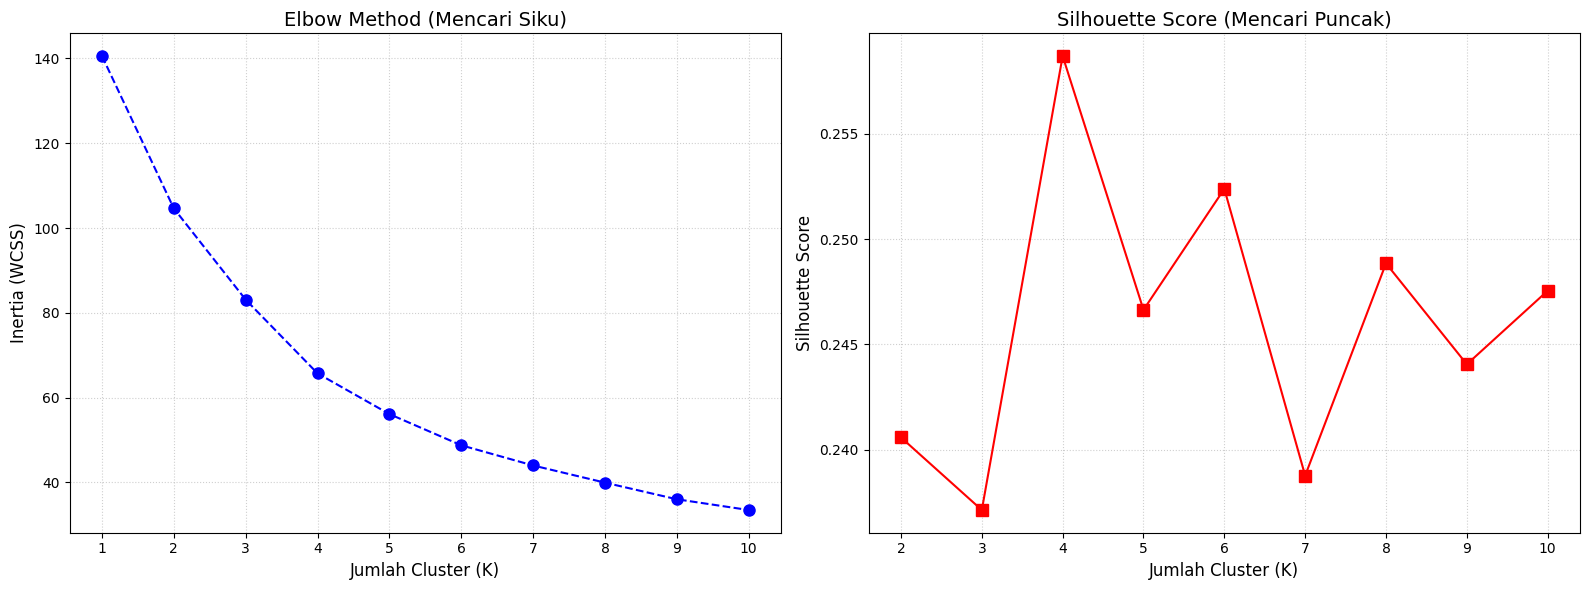

--- Ringkasan Metrik Evaluasi Clustering ---
 K    Inertia  Silhouette Score
 2 104.610748          0.240582
 3  83.094232          0.237139
 4  65.713113          0.258684
 5  56.117808          0.246638
 6  48.758753          0.252381
 7  43.999074          0.238771
 8  39.952700          0.248844
 9  36.029390          0.244055
10  33.491631          0.247545


In [25]:
# Inisialisasi list untuk menyimpan metrik evaluasi
inertia = []
silhouette_avgs = []
K_range = range(1, 11) # Mencoba dari 1 sampai 10 cluster

# Perulangan untuk menghitung metrik setiap K
for k in K_range:
    # Inisialisasi model KMeans
    # n_init=10 untuk memastikan stabilitas hasil (menghindari inisialisasi buruk)
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_clustering)

    # Simpan Inertia (untuk Elbow Method)
    inertia.append(kmeans.inertia_)

    # Simpan Silhouette Score (untuk K >= 2 saja)
    if k > 1:
        score = silhouette_score(X_clustering, kmeans.labels_)
        silhouette_avgs.append(score)

# isualisasi Hasil
plt.figure(figsize=(16, 6))

# Plot Kiri: Elbow Method
plt.subplot(1, 2, 1)
plt.plot(K_range, inertia, marker='o', linestyle='--', color='blue', markersize=8)
plt.title('Elbow Method (Mencari Siku)', fontsize=14)
plt.xlabel('Jumlah Cluster (K)', fontsize=12)
plt.ylabel('Inertia (WCSS)', fontsize=12)
plt.xticks(K_range)
plt.grid(True, linestyle=':', alpha=0.6)

# Plot Kanan: Silhouette Analysis
plt.subplot(1, 2, 2)
# Silhouette score mulai dari K=2
plt.plot(range(2, 11), silhouette_avgs, marker='s', linestyle='-', color='red', markersize=8)
plt.title('Silhouette Score (Mencari Puncak)', fontsize=14)
plt.xlabel('Jumlah Cluster (K)', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.xticks(range(2, 11))
plt.grid(True, linestyle=':', alpha=0.6)

plt.tight_layout()
plt.show()

# Menampilkan Ringkasan Data dalam Tabel
results_summary = pd.DataFrame({
    'K': range(2, 11),
    'Inertia': inertia[1:],
    'Silhouette Score': silhouette_avgs
})

print("--- Ringkasan Metrik Evaluasi Clustering ---")
print(results_summary.to_string(index=False))

In [26]:
# Eksperimen K=3
kmeans3 = KMeans(n_clusters=3, random_state=42, n_init=10)
df_model['cluster_k3'] = kmeans3.fit_predict(X_clustering)

# Eksperimen K=4
kmeans4 = KMeans(n_clusters=4, random_state=42, n_init=10)
df_model['cluster_k4'] = kmeans4.fit_predict(X_clustering)

# Fungsi untuk melihat karakteristik asli (bukan yang scale)
def get_profile(df, cluster_col):
    return df.groupby(cluster_col)[[
        'avg_time_to_hire', 'avg_cost_per_hire', 'avg_OAR', 'hiring_count'
    ]].mean().sort_values('avg_OAR', ascending=False)

print("--- PROFIL JIKA MENGGUNAKAN K=3 ---")
print(get_profile(df_model, 'cluster_k3'))

print("\n--- PROFIL JIKA MENGGUNAKAN K=4 ---")
print(get_profile(df_model, 'cluster_k4'))

--- PROFIL JIKA MENGGUNAKAN K=3 ---
            avg_time_to_hire  avg_cost_per_hire   avg_OAR  hiring_count
cluster_k3                                                             
0                  48.977402        5300.102804  0.677705     51.393939
1                  43.413245        5390.340453  0.639403     52.333333
2                  48.425606        4950.007863  0.635550     52.781250

--- PROFIL JIKA MENGGUNAKAN K=4 ---
            avg_time_to_hire  avg_cost_per_hire   avg_OAR  hiring_count
cluster_k4                                                             
2                  50.080155        5281.412727  0.680230     50.680000
0                  44.207906        5525.670389  0.652875     53.909091
3                  45.232044        4859.759817  0.647544     51.370370
1                  49.566015        5223.847479  0.617393     53.222222


### Perbandingan 5 model clustering

In [27]:
# Tetapkan K = 3 berdasarkan keputusan bisnis
k_final = 3

# Siapkan list untuk menyimpan skor
model_comparison = []

# 1. K-Means
km = KMeans(n_clusters=k_final, random_state=42, n_init=10)
km_labels = km.fit_predict(X_clustering)
model_comparison.append(['K-Means', silhouette_score(X_clustering, km_labels),
                         davies_bouldin_score(X_clustering, km_labels),
                         calinski_harabasz_score(X_clustering, km_labels)
                         ])

# 2. Agglomerative (Hierarchical)
agg = AgglomerativeClustering(n_clusters=k_final)
agg_labels = agg.fit_predict(X_clustering)
model_comparison.append(['Agglomerative', silhouette_score(X_clustering, agg_labels),
                         davies_bouldin_score(X_clustering, agg_labels),
                         calinski_harabasz_score(X_clustering, agg_labels)
                         ])

# 3. Gaussian Mixture (GMM)
gmm = GaussianMixture(n_components=k_final, random_state=42)
gmm_labels = gmm.fit_predict(X_clustering)
model_comparison.append(['GMM', silhouette_score(X_clustering, gmm_labels),
                         davies_bouldin_score(X_clustering, gmm_labels),
                         calinski_harabasz_score(X_clustering, gmm_labels)
                         ])

# 4. Bisecting K-Means
bisect = BisectingKMeans(n_clusters=k_final, random_state=42)
bisect_labels = bisect.fit_predict(X_clustering)
model_comparison.append(['Bisecting K-Means', silhouette_score(X_clustering, bisect_labels),
                         davies_bouldin_score(X_clustering, bisect_labels),
                         calinski_harabasz_score(X_clustering, bisect_labels)
                         ])

# 5. Spectral Clustering
spectral = SpectralClustering(n_clusters=k_final, random_state=42, affinity='nearest_neighbors')
spectral_labels = spectral.fit_predict(X_clustering)
model_comparison.append(['Spectral Clustering', silhouette_score(X_clustering, spectral_labels),
                         davies_bouldin_score(X_clustering, spectral_labels),
                         calinski_harabasz_score(X_clustering, spectral_labels)
                         ])

# Tampilkan Perbandingan
df_compare = pd.DataFrame(model_comparison, columns=['Model', 'Silhouette Score', 'Davies Bouldin Score', 'Calinski Harabasz Score'])
print("--- PERBANDINGAN 5 MODEL CLUSTERING (K=3) ---")
print(df_compare.sort_values(by=['Silhouette Score','Davies Bouldin Score','Calinski Harabasz Score'], ascending=False))

--- PERBANDINGAN 5 MODEL CLUSTERING (K=3) ---
                 Model  Silhouette Score  Davies Bouldin Score  \
0              K-Means          0.237139              1.314110   
4  Spectral Clustering          0.232855              1.319099   
2                  GMM          0.232105              1.347049   
1        Agglomerative          0.224747              1.325891   
3    Bisecting K-Means          0.210448              1.360539   

   Calinski Harabasz Score  
0                30.776216  
4                30.341843  
2                29.803155  
1                27.682096  
3                26.544495  


In [28]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   job_title                 92 non-null     object 
 1   source                    92 non-null     object 
 2   avg_time_to_hire          92 non-null     float64
 3   avg_cost_per_hire         92 non-null     float64
 4   avg_OAR                   92 non-null     float64
 5   hiring_count              92 non-null     int64  
 6   efficiency_score          92 non-null     float64
 7   efficiency_score_scaled   92 non-null     float64
 8   avg_time_to_hire_scaled   92 non-null     float64
 9   avg_cost_per_hire_scaled  92 non-null     float64
 10  avg_OAR_scaled            92 non-null     float64
 11  efficiency_score_final    92 non-null     float64
 12  cluster_k3                92 non-null     int32  
 13  cluster_k4                92 non-null     int32  
dtypes: float64(9

### Visualisasi Cluster (PCA)

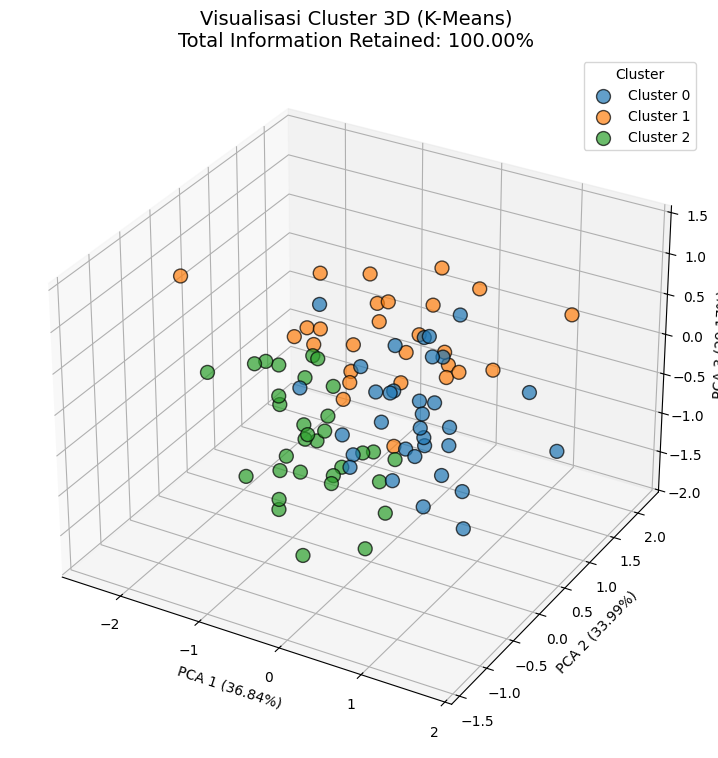

Total informasi yang berhasil dipertahankan dalam 3D: 100.00%


In [29]:
# Reduksi Dimensi dengan PCA menjadi 3 komponen
df_model['cluster'] = km_labels

pca_3d = PCA(n_components=3)
pca_result_3d = pca_3d.fit_transform(X_clustering)

# Masukkan hasil ke dataframe
df_model['pca_1'] = pca_result_3d[:, 0]
df_model['pca_2'] = pca_result_3d[:, 1]
df_model['pca_3'] = pca_result_3d[:, 2]


# Setup Plot 3D
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

# Plotting data berdasarkan cluster
# Kita gunakan scatter per cluster agar legend muncul dengan benar
colors = ['#440154', '#21918c', '#fde725'] # Warna viridis manual atau gunakan cmap
for i in range(3):
    cluster_data = df_model[df_model['cluster'] == i] # Changed 'cluster' to 'cluster_k3'
    ax.scatter(
        cluster_data['pca_1'],
        cluster_data['pca_2'],
        cluster_data['pca_3'],
        label=f'Cluster {i}',
        s=100,
        alpha=0.7,
        edgecolor='k'
    )

# Labeling
total_variance_3d = np.sum(pca_3d.explained_variance_ratio_) * 100
ax.set_title(f'Visualisasi Cluster 3D (K-Means)\nTotal Information Retained: {total_variance_3d:.2f}%', fontsize=14)
ax.set_xlabel(f'PCA 1 ({pca_3d.explained_variance_ratio_[0]*100:.2f}%)')
ax.set_ylabel(f'PCA 2 ({pca_3d.explained_variance_ratio_[1]*100:.2f}%)')
ax.set_zlabel(f'PCA 3 ({pca_3d.explained_variance_ratio_[2]*100:.2f}%)')

ax.legend(title='Cluster')
plt.show()

print(f"Total informasi yang berhasil dipertahankan dalam 3D: {total_variance_3d:.2f}%")

In [30]:
# Membuat plot interaktif 3D
fig = px.scatter_3d(
    df_model,
    x='pca_1', y='pca_2', z='pca_3',
    color='cluster',
    title=f'Interactive 3D Cluster Visualization (Variance: {total_variance_3d:.2f}%)',
    labels={'pca_1': 'PCA 1', 'pca_2': 'PCA 2', 'pca_3': 'PCA 3'},
    opacity=0.8,
    hover_data=['job_title', 'source'] # Menampilkan detail saat kursor menempel
)

fig.show()

### EValuasi

In [31]:
# Menghitung Technical Success Metrics
db_index = davies_bouldin_score(X_clustering, km_labels)
ch_index = calinski_harabasz_score(X_clustering, km_labels)
sil_score = silhouette_score(X_clustering, km_labels)

# Menampilkan Hasil
print("--- HASIL EVALUASI TEKNIS SPECTRAL CLUSTERING (K=3) ---")
print(f"1. Silhouette Score (Tinggi = Bagus)      : {sil_score:.4f}")
print(f"2. Davies-Bouldin Index (Rendah = Bagus)  : {db_index:.4f}")
print(f"3. Calinski-Harabasz Index (Tinggi = Bagus): {ch_index:.4f}")

--- HASIL EVALUASI TEKNIS SPECTRAL CLUSTERING (K=3) ---
1. Silhouette Score (Tinggi = Bagus)      : 0.2371
2. Davies-Bouldin Index (Rendah = Bagus)  : 1.3141
3. Calinski-Harabasz Index (Tinggi = Bagus): 30.7762


### Interpretasi Cluster


In [32]:
# Menghitung Rata-rata Karakteristik Asli per Cluster
# Kita gunakan kolom original (bukan _scaled) agar mudah dipahami
cluster_profile = df_model.groupby('cluster').agg(
    avg_OAR=('avg_OAR', 'mean'),
    avg_cost=('avg_cost_per_hire', 'mean'),
    avg_time=('avg_time_to_hire', 'mean'),
    hiring_volume=('hiring_count', 'sum'),
    total_combinations=('job_title', 'count')
).sort_values(by='avg_OAR', ascending=False)

print("--- PROFILING CLUSTER (RECRUITMENT STRATEGY) ---")
print(cluster_profile)

# Melihat Contoh Kombinasi di Setiap Cluster
print("\n--- CONTOH KOMBINASI PER CLUSTER ---")
for c in cluster_profile.index:
    print(f"\nCluster {c}:")
    display(df_model[df_model['cluster'] == c][['job_title', 'source', 'efficiency_score_final']].head(3))

--- PROFILING CLUSTER (RECRUITMENT STRATEGY) ---
          avg_OAR     avg_cost   avg_time  hiring_volume  total_combinations
cluster                                                                     
0        0.677705  5300.102804  48.977402           1696                  33
1        0.639403  5390.340453  43.413245           1413                  27
2        0.635550  4950.007863  48.425606           1689                  32

--- CONTOH KOMBINASI PER CLUSTER ---

Cluster 0:


,job_title,source,efficiency_score_final
2,Account Executive,Recruiter,70.633330
6,Accountant,Recruiter,46.839451
8,Backend Developer,Job Portal,69.457971



Cluster 1:


,job_title,source,efficiency_score_final
4,Accountant,Job Portal,82.746219
5,Accountant,LinkedIn,38.648057
12,Business Development Manager,Job Portal,98.584221



Cluster 2:


,job_title,source,efficiency_score_final
0,Account Executive,Job Portal,75.116065
1,Account Executive,LinkedIn,82.090749
3,Account Executive,Referral,34.651234


## Simpan Datasets baru

In [33]:
df_model.sample(5)

,job_title,source,avg_time_to_hire,avg_cost_per_hire,avg_OAR,hiring_count,efficiency_score,efficiency_score_scaled,avg_time_to_hire_scaled,avg_cost_per_hire_scaled,avg_OAR_scaled,efficiency_score_final,cluster_k3,cluster_k4,cluster,pca_1,pca_2,pca_3
62,SEO Analyst,Recruiter,51.229167,6055.831250,0.670417,48,-0.594792,-1.249669,0.827351,1.714781,0.420581,10.377794,0,2,0,1.771986,0.775395,-0.569061
74,Social Media Manager,Recruiter,51.883721,4869.717209,0.693488,43,-0.444852,0.343939,0.961524,-0.764229,0.979151,64.565371,0,2,0,0.692838,-1.382994,0.238583
9,Backend Developer,LinkedIn,45.804348,5515.059565,0.670435,46,-0.471637,0.059262,-0.284647,0.584554,0.421020,54.885459,0,0,0,0.528837,0.523860,0.382392
7,Accountant,Referral,53.705882,5250.126078,0.617451,51,-0.615776,-1.472697,1.335037,0.030836,-0.861727,2.794153,2,1,2,0.223842,-0.434711,-1.505342
32,HR Coordinator,Job Portal,41.638298,5492.523191,0.684894,47,-0.397801,0.844006,-1.138619,0.537452,0.771070,81.569192,1,0,1,0.284126,0.862976,1.206490


In [34]:
# Drop cluster_k3 & cluster_k4
df_model.drop(columns=['cluster_k3', 'cluster_k4'], inplace=True)
df_model.sample(5)

,job_title,source,avg_time_to_hire,avg_cost_per_hire,avg_OAR,hiring_count,efficiency_score,efficiency_score_scaled,avg_time_to_hire_scaled,avg_cost_per_hire_scaled,avg_OAR_scaled,efficiency_score_final,cluster,pca_1,pca_2,pca_3
50,Product Analyst,Recruiter,43.187500,4839.045833,0.685625,48,-0.346802,1.386040,-0.821058,-0.828333,0.788777,100.000000,0,-0.366110,-0.377296,1.280289
69,Sales Representative,LinkedIn,49.641509,4641.177925,0.625660,53,-0.490327,-0.139388,0.501908,-1.241882,-0.662976,48.130762,2,-0.841378,-1.011269,-0.563904
47,Payroll Specialist,Referral,48.134615,5132.460769,0.688846,52,-0.433444,0.465185,0.193019,-0.215088,0.866762,68.688100,0,0.564722,-0.494092,0.551994
38,HR Manager,Recruiter,43.770492,5502.009344,0.650328,61,-0.474183,0.032201,-0.701554,0.557278,-0.065772,53.965296,1,0.000694,0.879855,0.305876
84,UI Designer,Job Portal,47.786885,5496.242131,0.659672,61,-0.509207,-0.340044,0.121740,0.545225,0.160454,41.307832,0,0.550097,0.342382,-0.066168


In [35]:
# Save the final datasets with cluster
df_model.to_csv('datasets_cluster.csv', index=False)